In [25]:
## QRAKEN: Quantum Random Keys via Entanglement. QRAKEN is a certified quantum random number generator for the Qiskit framework.
## Repository: https://github.com/HermanniH/QRAKEN
## Qiskit backend code written by Tobias Haug, comments to tobias.haug@u.nus.edu
## QRAKEN members: Tobias Haug, Hermanni Heimonen, Kishor Bharti

%matplotlib inline
# standard-ish Qiskit libraries
import qiskit
from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit, execute, Aer, IBMQ
import os

#Insert IBMQ account string here
#IBMQ.save_account('',overwrite=True) #save access code locally
#IBMQ.enable_account('') # access code only saved in memory

import time
import pickle


import numpy as np
import binascii
# about transpiling, compiling, and executing
from qiskit.compiler import transpile

# For graphs
from qiskit.tools.jupyter import *
from qiskit.visualization import *

# Aer noise models
from qiskit.providers.aer import noise


#Load credentials
IBMQ.load_account()

def flatten(l):
    return [item for sublist in l for item in sublist]

qiskit.__qiskit_version__

D:\Anaconda3\envs\qiskit\lib\site-packages\qiskit\providers\ibmq\ibmqfactory.py:181: UserWarning: Credentials are already in use. The existing account in the session will be replaced.
  warnings.warn('Credentials are already in use. The existing '


{'qiskit-terra': '0.9.1',
 'qiskit-ignis': '0.2.0',
 'qiskit': '0.12.2',
 'qiskit-aer': '0.3.0',
 'qiskit-ibmq-provider': '0.3.3',
 'qiskit-aqua': '0.6.0'}

In [26]:
#set parameters
local=False #run locally (simulation) or on IBM (actual quantum machine)
provider_choice = "" #"copy-paste string in double quotes" (nothing else!), if empty, default is: hub='ibm-q', group='open', project='main'

designate_coupling_map_pair=[] #empty list to choose best solution according to errors of CNOT, single qubit and read-out error

#designate_coupling_map_pair=[[0,1],[3,4]]  #set which qubits to use on machine, enter as a pair of two coupled together, must be of form [[0,1]] or [[0,1],[3,4]]




machine='ibmqx2' #which IBM machine to use #ibmqx2 #ibmq_vigo #'ibmq_ourense'#'ibmq_16_melbourne' #qasm_simulator
    

dataset='myrandom' #name of dataset
dataset+="_"+machine+"_"

layoutFindMode=0 #0: find recursivly all layouts with highest number of possible pairs, pick one with lowest error 1: Get best pairs by sorting them according to their errors, then picking them top down

x_boost=True  #Default: True, adds x gates after the c-x. Increases violation.

dataset+='b'+str(int(x_boost))

mode=0 #use which state preparation scheme, 0: maximal violation, 1: scheme with less violation 

if(mode!=0): #add mode to dataset name
    dataset+="m"+str(mode)


Nrepeatcircuits=0 #re-run measurement circuits in order to increase number of data gathered in one run. set to 0 to run maximal amount of time



for i in range(len(designate_coupling_map_pair)):
    if(len(designate_coupling_map_pair[i])!=2):
        raise NameError("designate_coupling_map_pair should empty list or a list of consisting of a list of two numbers, e.g. [[0,1]] or [[0,1],[3,4]]")


if(local==True): #flag dataset if run locally
    dataset="Simulated_"+dataset



In [27]:
floatformat='02.7f' #format to print out floats
NmeasurementSettings=4 #number of circuits of Bell inequality
Nbits=2 #consider two bits for a pair, set to 2
dimPair=2**Nbits #number of states in a pair
memory=True #get data of all shots



if(local==True): #run on local simulator
    backendRun = Aer.get_backend('qasm_simulator')
    #get noise and coupling map for simulation
    backend = IBMQ.get_provider().get_backend(machine)
    backendConfig=backend.configuration()
    properties = backend.properties()
    coupling_map = backendConfig.coupling_map
    noise_model = noise.device.basic_device_noise_model(properties)
    basis_gates = noise_model.basis_gates
    

else: #send job to IBM quantum device
    if provider_choice == "":
        provider = IBMQ.get_provider(hub='ibm-q', group='open', project='main') #Choose default provider
        backend = provider.get_backend(machine) #get IBM backend
        
    else:
        #This is poorly written code, but fast to write.
        provider_info = provider_choice.split()
        provider = IBMQ.get_provider(hub=provider_info[0][5:-2], group=provider_info[1][7:-2], project=provider_info[2][9:-1]) #get IBM backend
        backend = provider.get_backend(machine) #get IBM backend


    backendRun=backend
    backendConfig=backend.configuration()
    properties = backend.properties()
    """ #Test using saved setup
    infile=open( "x.pcl", "rb" )
    [properties,backendConfig]=pickle.load(infile)
    infile.close()
    """
    coupling_map = backendConfig.coupling_map
    

shots=backendConfig.max_shots #should not be larger than 8192 or 2**13

if(Nrepeatcircuits==0):
    Nrepeatcircuits=backendConfig.max_experiments//NmeasurementSettings #Set repeat circuits to maximal possible amount
    



NallCircuits=Nrepeatcircuits*NmeasurementSettings #should not be larger than backend.configuration().max_experiments
     
maxqubits=backendConfig.n_qubits #maximum number of qubits allowed in machine




if(memory==True):
    if(backendConfig.memory==False):
        print("Error: Memory not supported by machine",machine, "cannot output any bitstrings for randon number generation")
        memory=False
    
if(local==False):
    print("Max shots set",shots,", Max shots allowed",backendConfig.max_shots)
    print("repeated circuits (Nrepeatcircuits)",Nrepeatcircuits,", Maximum value allowed for Nrepeatcircuits",backendConfig.max_experiments//NmeasurementSettings)
    print("Number circuits set",NallCircuits,", Max circuits allowed",backendConfig.max_experiments)
    if(shots>backendConfig.max_shots):
        raise NameError("shots number not supported by machine, reduce to",backendConfig.max_shots)
    if(NallCircuits>backendConfig.max_experiments):
        raise NameError("Number of circuits too large, try reducing Nrepeatcircuits to",backendConfig.max_experiments//NmeasurementSettings)

    if(len(flatten(designate_coupling_map_pair))>maxqubits):
        raise NameError("Number of parallelized qubit pairs too large, try reducing designate_coupling_map_pair to an empty list or restrict entries to",maxqubits)



Max shots set 8192 , Max shots allowed 8192
repeated circuits (Nrepeatcircuits) 18 , Maximum value allowed for Nrepeatcircuits 18
Number circuits set 72 , Max circuits allowed 75


In [28]:
try:
    %qiskit_backend_overview #Plot overview over all backends
except:
    print('WARN: Overview over backends does not work')

WARN: Overview over backends does not work


In [29]:
backend #Plot used backend

<IBMQBackend('ibmqx2') from IBMQ(hub='ibm-q', group='open', project='main')>

In [30]:
if(len(designate_coupling_map_pair)!=0): #Choose manually defined layout of qubits
    print("Use user-defined qubit pairs",designate_coupling_map_pair)
    coupling_map_pair=designate_coupling_map_pair
else: #choose best layout from error map
    print("Find best Layout of qubit pairs from read-out errors, single-qubit errors and CNOT errors")
    #Check for Errors in different qubits and couplings, and choose best ones
    propertiesQubits=properties.qubits
    readout_errorList=[] #readout error from each qubit
    for i in range(maxqubits):
        for j in range(len(propertiesQubits[i])):
            if(propertiesQubits[i][j].name=="readout_error"):
                readout_errorList.append(propertiesQubits[i][j].value)
    couplingMapFull=np.unique(np.sort(coupling_map,axis=1),axis=0) #returns coupling map of only unique entries

    graphStructure=couplingMapFull

    propertiesGates=properties.gates

    cNotErrorUnsortedList=[] #CNOT error of coupled qubits
    u3ErrorList=[None for i in range(maxqubits)]
    for i in range(len(propertiesGates)):
        if(propertiesGates[i].gate=="cx"): #Check if CNOT gate
            for j in range(len(couplingMapFull)):
                if(np.all(np.sort(propertiesGates[i].qubits)==couplingMapFull[j])): #Select which coupling it corresonds to
                    for k in range(len(propertiesGates[i].parameters)):
                        if(propertiesGates[i].parameters[k].name=="gate_error"):
                            cNotErrorUnsortedList.append([couplingMapFull[j],propertiesGates[i].parameters[k].value])
        if(propertiesGates[i].gate=="u3"): #Check if single qubit rotation
            for k in range(len(propertiesGates[i].parameters)):
                if(propertiesGates[i].parameters[k].name=="gate_error"):
                    u3ErrorList[propertiesGates[i].qubits[0]]=propertiesGates[i].parameters[k].value

    sortedcNotErrorIndex=np.unique([cNotErrorUnsortedList[i][0] for i in range(len(cNotErrorUnsortedList))],return_index=True,axis=0)[1]   #remove from cNotError lis doubled entries            
    cNotErrorList=[cNotErrorUnsortedList[sortedcNotErrorIndex[i]] for i in range(len(sortedcNotErrorIndex))]


#estimate error for a specific qubit pair by adding measurement errors, single qubit u3 error and CNOT error
def estimateError(coupling,readout_errorList,cNotErrorList,u3ErrorList):
    error=0
    for i in range(len(cNotErrorList)):
        if(np.all(cNotErrorList[i][0]==coupling)):
            error+=cNotErrorList[i][1]
            
    error+=readout_errorList[coupling[0]]+readout_errorList[coupling[1]]+u3ErrorList[coupling[0]]+u3ErrorList[coupling[1]]

    return error


estimatedErrorMap=[]
for i in range(len(couplingMapFull)):
    estimatedErrorMap.append([couplingMapFull[i],estimateError(couplingMapFull[i],readout_errorList,cNotErrorList,u3ErrorList)])


if(layoutFindMode==1):
    print("Find layout for pairs by sorting them according to error estimate, then picking them in ascending order and removing unavailable couplings")
    def runGetBestPairsOnly(estimatedErrorMap): #Gets best pairs, by sorting them according to  error in a list and picking them one after the other, if qubits of pair are still available. Result may not maximize number of possible pairs
        bestCouplings=[]
        bestErrors=[]
        
        argsortError=np.argsort([estimatedErrorMap[i][1] for i in range(len(estimatedErrorMap))])
        sortedErorMap=[estimatedErrorMap[argsortError[i]] for i in range(len(estimatedErrorMap))]

        while(len(sortedErorMap)>0): # go through all possible couplings
            bestCouplings.append(sortedErorMap[0][0])
            bestErrors.append(sortedErorMap[0][1])
            tempCouplings=np.array([sortedErorMap[i][0] for i in range(len(sortedErorMap))])
            deleteUnavailableCouplings=np.nonzero((tempCouplings==tempCouplings[0][0]) | (tempCouplings==tempCouplings[0][1]))[0]
            sortedErorMap=np.delete(sortedErorMap,deleteUnavailableCouplings,axis=0) #delete all couplings which are now unavailable after this choice of new pair


        return bestCouplings,bestErrors

    allLayouts=[runGetBestPairsOnly(estimatedErrorMap)[0]]
    
elif(layoutFindMode==0):
    print("Find layout for pairs by recursivly finding all coupling maps with highest number of pairs")

    if(maxqubits>17):
        minPairs=0 #minimum number of couplings
        maxPairs=10000 #maximum number of couplings
        getNotFilledSolutions=False #Get solutions which have left over possible couplings
        targetNumberPairs=0 #Get specific number of pairs if nonzero
        onlyReturnHighestFound=True # only return highest number of couplings
        randomizeSearch=3 #randomize coupling_map at every recurisve call if >0, number gives number of restarts of algorithm
        maxsolutions=0 #find only this many solutions, then abort
        maxtime=20 #maximal runtime in seconds
        if(targetNumberPairs>0):
            minPairs=targetNumberPairs
            maxPairs=targetNumberPairs
            getNotFilledSolutions=True
    else:
        minPairs=0 #minimum number of couplings
        maxPairs=10000 #maximum number of couplings
        getNotFilledSolutions=False #Get solutions which have left over possible couplings
        targetNumberPairs=0 #Get specific number of pairs if nonzero
        onlyReturnHighestFound=True # only return highest number of couplings
        randomizeSearch=1 #randomize coupling_map at every recurisve call if >0, number gives number of restarts of algorithm
        maxsolutions=0 #find only this many solutions, then abort
        maxtime=10000 #maximal runtime in seconds
        if(targetNumberPairs>0):
            minPairs=targetNumberPairs
            maxPairs=targetNumberPairs
            getNotFilledSolutions=True

    #recursive function to find pairs of couplings. Given a number of selected pairs already, selects all possible next choice of pair, then recursivly calls itself. 
    def recursiveFindPairs(selectedPairs,couplingMap,ini=1,highestnumberPairsReached=0): # make sure ini=1 for call
        global _highestnumberPairsReached,_solutionsFound,_starttimerec
        if(ini==1): #Initialize internal counter that is shared inside the recursive algorithm
            _highestnumberPairsReached=highestnumberPairsReached
            _solutionsFound=0
            _starttimerec=time.time()
        newSelectedPairsList=[]
        currentLengthPairs=len(selectedPairs)
        leftoverPairs=len(couplingMap)


        if(randomizeSearch>0): #Randomize order to achieve different results in each run
            x=np.arange(leftoverPairs)
            np.random.shuffle(x)
            couplingMap=couplingMap[x]

        levelCouplingMap=couplingMap



        if(leftoverPairs>0):  #if still pairs available
            if(_highestnumberPairsReached<currentLengthPairs+1): #calculate highest pair found so far
                _highestnumberPairsReached=currentLengthPairs+1
                #print(_highestnumberPairsReached)

        for i in range(len(couplingMap)): # go through all possible couplings at this point
            #levelCouplingMap=np.array(levelCouplingMap) #copy available couplings to new array

            newSelectedPairs=np.array(selectedPairs)
            if(len(selectedPairs)>0): #check if this is first pair
                newSelectedPairs=np.append(newSelectedPairs,[couplingMap[i]],axis=0) #append new coupling pair
            else:
                newSelectedPairs=np.array([couplingMap[i]]) #make first pair

            levelCouplingMap=np.delete(levelCouplingMap,0,axis=0) #delete selected pair from list of couplings


            deleteUnavailableCouplings=np.nonzero((levelCouplingMap==couplingMap[i][0]) | (levelCouplingMap==couplingMap[i][1]))[0]
            newCouplingMap=np.delete(levelCouplingMap,deleteUnavailableCouplings,axis=0) #delete all couplings which are now unavailable after this choice of new pair

            if(onlyReturnHighestFound==False or (len(newSelectedPairs)+len(newCouplingMap))>=_highestnumberPairsReached): # if onlyReturnHighestFound==True check if number of theoretical possible pairs is equal or higher than highestnumberPairsReached
                if(len(newCouplingMap)>0): #if still pairs available
                    if(getNotFilledSolutions==True and len(newSelectedPairs)>=minPairs and len(newSelectedPairs)<=maxPairs): #add this solution although other pairs still available if getNotFilledSolutions==True
                        newSelectedPairsList.append(newSelectedPairs)
                        _solutionsFound+=1
                        if(_solutionsFound%100==0): #print to monitor progress
                            print(_solutionsFound)
                        if(maxsolutions!=0 and _solutionsFound>=maxsolutions): #stop if found enough solutions
                            break
                        if(time.time()-_starttimerec>maxtime): #stop if out of time
                            break

                    if(len(newSelectedPairs)<maxPairs):
                        newSelectedPairsList+=recursiveFindPairs(newSelectedPairs,newCouplingMap,ini=0) #next recursive step
                        if(maxsolutions!=0 and _solutionsFound>=maxsolutions):
                            break
                        if(time.time()-_starttimerec>maxtime):
                            break
                else:
                    if(len(newSelectedPairs)>=minPairs and len(newSelectedPairs)<=maxPairs): # if all pairs selected, append to list of solutions
                        newSelectedPairsList.append(newSelectedPairs)
                        _solutionsFound+=1
                        if(_solutionsFound%100==0): #print to monitor progress
                            print(_solutionsFound)
                        if(maxsolutions!=0 and _solutionsFound>=maxsolutions): #stop if found enough solutions
                            break
                        if(time.time()-_starttimerec>maxtime): #stop if out of time
                            break

        return newSelectedPairsList

    startrec=time.time()

    allLayouts=recursiveFindPairs([],couplingMapFull) #all possible layouts of qubit pairs in circuit
    for i in range(randomizeSearch-1): #if randomize is greater 1, re-run algorithm to try different randomized paths
        print("Restart recursive algorithm to try different path")
        allLayouts+=recursiveFindPairs([],couplingMapFull,highestnumberPairsReached=_highestnumberPairsReached) #all possible layouts of qubit pairs in circuit

    print('Time recursive search',time.time()-startrec)
    
    
    
#allLayouts 
#get layouts with maximal number of pairs
if(len(allLayouts)==0):
    raise NameError("ERROR: Could not find any suitable layouts")
maxLayout=np.amax([len(allLayouts[i]) for i in range(len(allLayouts))])
maxLayoutIndexList=np.nonzero([len(allLayouts[i])==maxLayout for i in range(len(allLayouts))])[0]
maxLayoutList=[allLayouts[maxLayoutIndexList[i]] for i in range(len(maxLayoutIndexList))]
print("Maximal number of pairs found",maxLayout, ", found",len(maxLayoutList),"possible solutions")
#print(maxLayoutList)



print("Estimate errors of possible layout solutions")
estimateErrorList=[np.sum([estimateError(coupling,readout_errorList,cNotErrorList,u3ErrorList) for coupling in maxLayoutList[i]]) for i in range(len(maxLayoutList))]
bestIndex=np.argsort(estimateErrorList)[0]
bestLayout=maxLayoutList[bestIndex]
print("Best Layout with estimated Error", estimateErrorList[bestIndex])
coupling_map_pair=bestLayout
bestLayout

Find best Layout of qubit pairs from read-out errors, single-qubit errors and CNOT errors
Find layout for pairs by recursivly finding all coupling maps with highest number of pairs
Time recursive search 0.002002716064453125
Maximal number of pairs found 2 , found 5 possible solutions
Estimate errors of possible layout solutions
Best Layout with estimated Error 0.10153199740368453


array([[0, 1],
       [2, 4]])

In [32]:
initial_layout=flatten(coupling_map_pair) #layout of physical qubits used

newstring="_I"
for i in range(len(initial_layout)):
    newstring+="_"+str(initial_layout[i])

if(dataset.find(newstring)==-1):
   dataset+=newstring



if not os.path.exists(dataset):
    print('Generating folder',dataset,', store all results here.')
    os.makedirs(dataset)
else:
    print('Folder',dataset,'already exists, store all results here.')
    
#get errors for qubit pairs actually used
print("Show error for qubits used")
QubitsUsedMeasurementError=[]
u3UsedError=[]
for i in range(len(coupling_map_pair)):
    for j in range(2):
        QubitsUsedMeasurementError.append([2*i+j,coupling_map_pair[i][j],readout_errorList[coupling_map_pair[i][j]]])
        u3UsedError.append([2*i+j,coupling_map_pair[i][j],u3ErrorList[coupling_map_pair[i][j]]])
        print("Error of qbit number",2*i+j,"physical position",coupling_map_pair[i][j],"Readout Error",readout_errorList[coupling_map_pair[i][j]],"U3 error",u3ErrorList[coupling_map_pair[i][j]])

print("")
CNOTsUsedError=[]
for i in range(len(coupling_map_pair)):
    for j in range(len(couplingMapFull)):
        if(np.all(cNotErrorList[j][0]==np.sort(coupling_map_pair[i]))):
            CNOTsUsedError.append([i,coupling_map_pair[i],cNotErrorList[j][1]])
            print(i,coupling_map_pair[i],"CNOT Error",cNotErrorList[j][1])
print("")


print("Estimated error for each pair")
for i in range(len(coupling_map_pair)):
    print("pair",i,coupling_map_pair[i],estimateError(coupling_map_pair[i],readout_errorList,cNotErrorList,u3ErrorList))
    ##QubitsUsedMeasurementError[2*i][2]+QubitsUsedMeasurementError[2*i+1][2]+CNOTsUsedError[i][2]+u3UsedError[2*i][2]+u3UsedError[2*i+1][2])
    
    
Nqubitpairs=len(coupling_map_pair)
 
print("Bits Generated per run", Nqubitpairs*NallCircuits*shots*Nbits)

Folder myrandom_ibmqx2_b1_I_0_1_2_4 already exists, store all results here.
Show error for qubits used
Error of qbit number 0 physical position 0 Readout Error 0.011500000000000066 U3 error 0.0011779701263860273
Error of qbit number 1 physical position 1 Readout Error 0.014499999999999957 U3 error 0.0007379708506973321
Error of qbit number 2 physical position 2 Readout Error 0.02300000000000002 U3 error 0.0010564480678613595
Error of qbit number 3 physical position 4 Readout Error 0.01750000000000007 U3 error 0.0010879237580115053

0 [0 1] CNOT Error 0.01326867370706783
1 [2 4] CNOT Error 0.01770301089366036

Estimated error for each pair
pair 0 [0 1] 0.041184614684151216
pair 1 [2 4] 0.06034738271953331
Bits Generated per run 2359296


In [8]:
InequalityTheory=2*np.sqrt(2) #theoretic maximal value for CHSH inequality
InequalityClassicBound=2 #classic bound for CHSH inequality
circuitstring=['00','01','10','11'] #measurement settings
dictStates=['00','01','10','11'] #output states of two pairs


#maps measurement results for two quibit measurement 0 or 1 to either +1 or -1. This is used to generate the expectation value.
#stands for bit result ket(00) --> 1, ket(01)-->-1  ket(10)-->-1 ket(11)-->1
mappingBitResultToPM=np.array([1,-1,-1,1]) 

#define CHSHS inequality. We have 4 terms ZZ, ZX, XZ, XX, each generated by one of the circuits. We now assign three terms with +1, and one with -1. 
# The factors are multiplied with the average value of the respective circuits
if(mode==0):
    CHSHfactors=np.array([1,1,1,-1])
elif(mode==1):
    CHSHfactors=np.array([1,1,-1,1])



circuit=[None for i in range(NmeasurementSettings)]

#first step generates Bell state 00 + 11 by using a Hadamard and CNOT
qr = QuantumRegister(Nbits*Nqubitpairs, 'qr')
cr = ClassicalRegister(Nbits*Nqubitpairs, 'cr')
for i in range(NmeasurementSettings):
    circuit[i] = QuantumCircuit(qr, cr)
    for j in range(Nqubitpairs):
        circuit[i].h(qr[2*j])
        circuit[i].cx(qr[2*j], qr[2*j+1])
        if x_boost: #add sinlge qubit gates to correct errors introduced by CNOT
            circuit[i].barrier(qr[2*j+1])
            circuit[i].barrier(qr[2*j])
            circuit[i].x(qr[2*j])
            circuit[i].x(qr[2*j+1])
            circuit[i].barrier(qr[2*j+1])
            circuit[i].barrier(qr[2*j])

    #Next, implement measurements settings
    #Here, we generate circuits that implement rotations in the desired basis, and then measure in the computation basis
    #two ways to generate CHSH circuit
if(mode==0): #maximal violation
#four measurement settings, generate four circuits
    #ZW
    current=0
    for j in range(Nqubitpairs):
        circuit[current].s(qr[2*j+1])
        circuit[current].h(qr[2*j+1])
        circuit[current].t(qr[2*j+1])
        circuit[current].h(qr[2*j+1])

    #ZV
    current=1
    for j in range(Nqubitpairs):
        circuit[current].s(qr[2*j+1])
        circuit[current].h(qr[2*j+1])
        circuit[current].tdg(qr[2*j+1])
        circuit[current].h(qr[2*j+1])


    #XW
    current=2
    for j in range(Nqubitpairs):
        circuit[current].h(qr[2*j])
        circuit[current].s(qr[2*j+1])
        circuit[current].h(qr[2*j+1])
        circuit[current].t(qr[2*j+1])
        circuit[current].h(qr[2*j+1])

    #ZV
    current=3
    for j in range(Nqubitpairs):
        circuit[current].h(qr[2*j])
        circuit[current].s(qr[2*j+1])
        circuit[current].h(qr[2*j+1])
        circuit[current].tdg(qr[2*j+1])
        circuit[current].h(qr[2*j+1])

elif(mode==1): #does not generate maximal violation, only up to 2.77
    theta=-3*np.pi/16
    for i in range(NmeasurementSettings):
        for j in range(Nqubitpairs):
            circuit[i].u3(theta,0,0,qr[2*j])

    #ZZ gate
    #ZX gate
    for j in range(Nqubitpairs):
        circuit[1].h(qr[2*j+1])

        #XZ gate
        circuit[2].h(qr[2*j])

        #XX
        circuit[3].h(qr[2*j])
        circuit[3].h(qr[2*j+1])
    
    
    
for i in range(NmeasurementSettings):
    circuit[i].barrier()
#generate circuits with measurements
circuitMeas=[circuit[i].copy() for i in range(NmeasurementSettings)] 
for i in range(NmeasurementSettings):
    circuitMeas[i].measure(qr, cr)
    
for i in range(NmeasurementSettings):
    print(circuit[i].draw()) #draw circuits without measurements

         ┌───┐      ░ ┌───┐ ░                      ░ 
qr_0: |0>┤ H ├──■───░─┤ X ├─░──────────────────────░─
         └───┘┌─┴─┐ ░ ├───┤ ░ ┌───┐┌───┐┌───┐┌───┐ ░ 
qr_1: |0>─────┤ X ├─░─┤ X ├─░─┤ S ├┤ H ├┤ T ├┤ H ├─░─
         ┌───┐└───┘ ░ ├───┤ ░ └───┘└───┘└───┘└───┘ ░ 
qr_2: |0>┤ H ├──■───░─┤ X ├─░──────────────────────░─
         └───┘┌─┴─┐ ░ ├───┤ ░ ┌───┐┌───┐┌───┐┌───┐ ░ 
qr_3: |0>─────┤ X ├─░─┤ X ├─░─┤ S ├┤ H ├┤ T ├┤ H ├─░─
              └───┘ ░ └───┘ ░ └───┘└───┘└───┘└───┘ ░ 
 cr_0: 0 ════════════════════════════════════════════
                                                     
 cr_1: 0 ════════════════════════════════════════════
                                                     
 cr_2: 0 ════════════════════════════════════════════
                                                     
 cr_3: 0 ════════════════════════════════════════════
                                                     
         ┌───┐      ░ ┌───┐ ░                        ░ 
qr_0: |0>┤ H ├──■───░─┤ X 

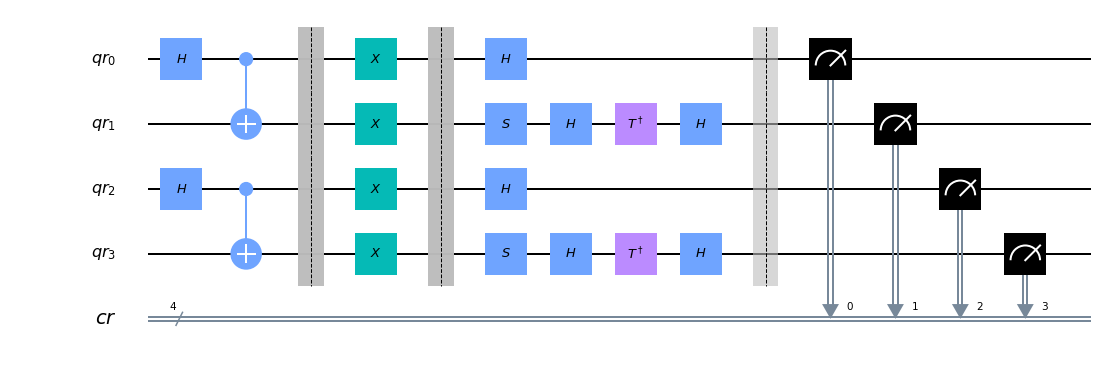

In [9]:
plotmeas=3 #Plots circuit number plotmeas nicely
fig=circuitMeas[plotmeas].draw(scale = 1,output='mpl')
fig

In [10]:
#Simulate circuit exactly as a reference using statevector_simulator backend
if(dimPair**Nqubitpairs<=2**14):# only run if system small enough
    simNqubitpairs=Nqubitpairs
    # Run the quantum circuit on a statevector simulator backend
    sv_simulator = Aer.get_backend('statevector_simulator')

    #The states outputed by the IBM machine are encoded as hex integer, and order of qubits is reversed, e.g. qubit 0 corresponds to last bit of state. Here, we reverse the order to get the right result, e.g. first physical qubit corresponds to first bit of state
    allStates=[] #all states measured in circuit
    for i in range(dimPair**simNqubitpairs):
        allStates.append(format(i, '0'+str(simNqubitpairs*2)+'b'))


    #sets all states k to one that identify with state of pair j for parallel measured qubit pair i mapStatesToParallel[i][j][k]
    mapStatesToParallel=np.zeros([simNqubitpairs,NmeasurementSettings,dimPair**simNqubitpairs])
    for i in range(simNqubitpairs):
        for j in range(dimPair):
            for k in range(dimPair**simNqubitpairs):
                if(allStates[k][2*i:2*(i+1)]==dictStates[j]):
                    mapStatesToParallel[i][j][k]=1


    #to generate state, use circuits without measurement
    outputvector=[None for i in range(NmeasurementSettings)]
    for i in range(NmeasurementSettings):
        # Execute the circuit
        jobStatevector = execute(circuit[i], sv_simulator)

        # Get the result
        resultStatevector = jobStatevector.result()
        outputstate = resultStatevector.get_statevector(circuit[i], decimals=20)
        outputvector[i]=outputstate

    #print(outputvector)



    probabilities=np.abs(np.array(outputvector))**2 #probablities of all states

    #map probabilities to one pair of 00,01,10,11
    probabilitiesMappedToPairTheory=[np.sum(np.sum(mapStatesToParallel,axis=0)*probabilities[i],axis=1)/simNqubitpairs for i in range(NmeasurementSettings)]

    theoryCountsMappedToPair=[{} for i in range(NmeasurementSettings)]
    for i in range(NmeasurementSettings):
        for m in range(dimPair):
            theoryCountsMappedToPair[i][dictStates[m]]=probabilitiesMappedToPairTheory[i][m]

    mappedtoZZSimulated=probabilitiesMappedToPairTheory*mappingBitResultToPM #map each state to a expectation Value of ZZ
    summedOverEachTermSimulated=np.sum(mappedtoZZSimulated,axis=1) #sum over result of each measurement Setting
    InequalitySimulated=np.sum(summedOverEachTermSimulated*CHSHfactors) #mulitiply with CHSH factors
    print("S from statevector",InequalitySimulated,"S from theory",InequalityTheory,"Difference",InequalityTheory-InequalitySimulated)
    print("Probabilities for each measurement setting and state")
    print(probabilitiesMappedToPairTheory)

else: #Use pre-calculated values
    if(mode==0):
        probabilitiesMappedToPairTheory=[np.array([0.4267767, 0.0732233, 0.0732233, 0.4267767]), np.array([0.4267767, 0.0732233, 0.0732233, 0.4267767]), np.array([0.4267767, 0.0732233, 0.0732233, 0.4267767]), np.array([0.0732233, 0.4267767, 0.4267767, 0.0732233])]
    elif(mode==1):
        probabilitiesMappedToPairTheory=[np.array([0.4578674, 0.0421326, 0.0421326, 0.4578674]), np.array([0.38889256, 0.11110744, 0.11110744, 0.38889256]), np.array([0.11110744, 0.38889256, 0.38889256, 0.11110744]), np.array([0.4578674, 0.0421326, 0.0421326, 0.4578674])]

S from statevector 2.8284271247461925 S from theory 2.8284271247461903 Difference -2.220446049250313e-15
Probabilities for each measurement setting and state
[array([0.4267767, 0.0732233, 0.0732233, 0.4267767]), array([0.4267767, 0.0732233, 0.0732233, 0.4267767]), array([0.4267767, 0.0732233, 0.0732233, 0.4267767]), array([0.0732233, 0.4267767, 0.4267767, 0.0732233])]


In [11]:
#we run the NmeasurementSettings each Nrepeatcircuits times to generate more data per run on the IBM machine
print('Prepare circuits for submission')
allcircuits=flatten([[circuitMeas[j].copy() for j in range(NmeasurementSettings)] for i in range(Nrepeatcircuits)])
for i in range(Nrepeatcircuits):
    for j in range(NmeasurementSettings):
        allcircuits[i*NmeasurementSettings+j].name="CircuitSetting"+str(j)+"Repeat"+str(i)
# 
#construct layout format, mapping virtual qubits qr[i] to physical qubits of initial_layout
layout={}
for i in range(len(initial_layout)):
    layout[qr[i]]=int(initial_layout[i])
#layout
            
#generate transpiler
#if(len(initial_layout)==0):
#    trans=transpile(allcircuits,backend)#,initial_layout=[0,1]
#else:
#    trans=transpile(allcircuits,backend,initial_layout=initial_layout)

Prepare circuits for submission


In [12]:
#Submit job
#jobIBMqx2 = execute(circuitMeas, ibmqx2, shots=shots,memory=True)#,meas_return='single',meas_level=0
startSubmissiontime=time.time()
if(local==True):
    print("Run with noise models of",machine,"locally")
    if(len(layout)==0):
        job = execute(allcircuits, backendRun, shots=shots,memory=memory,
                  coupling_map=coupling_map,
                  noise_model=noise_model,
                  basis_gates=basis_gates)
    else:
        job = execute(allcircuits, backendRun, shots=shots,memory=memory,
                  coupling_map=coupling_map,
                  noise_model=noise_model,
                  basis_gates=basis_gates,initial_layout=layout)
else:
    print("Run on IBM backend",machine)
    if(len(layout)==0):
        print("Run without initial_layout")
        job =execute(allcircuits,backendRun, shots=shots,memory=memory)
    else:
        print("Run with initial_layout",initial_layout)
        job =execute(allcircuits,backendRun, shots=shots,memory=memory,initial_layout=layout)


print("time taken to submit to IBM machine",machine,"queue",time.time()-startSubmissiontime)

Run on IBM backend ibmqx2
Run with initial_layout [0, 1, 2, 4]
time taken to submit to IBM machine ibmqx2 queue 9.063277959823608


In [13]:
#Check status of current job

#job = backend.retrieve_job(jobID) #retrieve job if jobID is known
## get the last 10 jobs on backend
#jobs = backend.jobs()

jobID=job.job_id()
print('Job ID: ', jobID)
print('Job status: ', job.status())
if(local==False):
    print("Queue position",job.queue_position())
    print("number jobs waiting",backendRun.status().pending_jobs)


Job ID:  5e4eaf8b1a7482001850aa16
Job status:  JobStatus.VALIDATING
Queue position None
number jobs waiting 4


In [14]:
# Grab the results from the job.
print("Waiting for job to finish and retrieve data")
startRetrievalTime=time.time()
result = job.result()
waittime=time.time()-startRetrievalTime
print("wait time for retrieval",waittime)

date=result.date

try:
    time_taken=result.time_taken
    print("Time taken to run on machine",time_taken)
except:
    print("WARN: Cannot get time_taken from machine...")
    time_taken=0

Waiting for job to finish and retrieve data
wait time for retrieval 1217.8504436016083
Time taken to run on machine 635.2335305213928


In [15]:
#Evaluate data
totalshots=shots*Nrepeatcircuits #total shots for each measurement setting
counts=[{} for i in range(NmeasurementSettings)] #store counts for each measurement state here
countsPairState=[[{} for i in range(NmeasurementSettings)] for p in range(Nqubitpairs)] #store counts for each measurement state here
totalcounts=np.zeros([Nqubitpairs,NmeasurementSettings])
#if(len(allStates)<2**10):
#    for i in range(NmeasurementSettings):
#        for m in range(len(allStates)):
#            counts[i][allStates[m]]=0

#countsVec=[None for i in range(NmeasurementSettings)] #counts ordered in a numpy vector
#measuredProbablity=[None for i in range(NmeasurementSettings)] #counts normalized to one 
measuredProbabilityPairState=np.zeros([Nqubitpairs,NmeasurementSettings,dimPair])
shotsResult=[[None for i in range(NmeasurementSettings)] for p in range(Nqubitpairs)] #outputs 0 or 1 for each measurement result
measSetting=[[None for i in range(NmeasurementSettings)] for p in range(Nqubitpairs)]#outputs 0 or 1 for each measurement Setting applied

print("Start evaluation of data")

for i in range(NmeasurementSettings):#add up counts from each measurement
    for k in range(Nrepeatcircuits): #add up counts from each repeated measurement setting
            tempgetcounts=result.get_counts(k*NmeasurementSettings+i) #dict of results from measurements in form state : counts
            for key in tempgetcounts.keys(): #iterate over counts for each measured state in tempgetcounts
                if key in counts[i]:
                    counts[i][key]+=tempgetcounts[key] #add results to i measurement setting
                else:
                    counts[i][key]=tempgetcounts[key] #create new key in dict if not exist yet



    for state in counts[i]:
        for p in range(Nqubitpairs):
            measuredProbabilityPairState[Nqubitpairs-1-p,i,int(state[Nbits*p:Nbits*(p+1)][::-1],2)]+=counts[i][state] #extract meausred pair from state, and add to counts for each Nqubitpairs. Reverse order of string due to Qiskit inverse ordering of states
        

    totalcounts[:,i]=np.sum(measuredProbabilityPairState[:,i,:],axis=-1) #total counts per measurement setting and qubit pair
    for p in range(Nqubitpairs):
        measuredProbabilityPairState[p,i,:]/=totalcounts[p,i] #Divide by total counts to get probabilities
    
    #make dict of measured state pairs
    for p in range(Nqubitpairs):
        for m in range(len(dictStates)):
            countsPairState[p][i][dictStates[m]]=measuredProbabilityPairState[p,i,m]
    

    if(memory==True): #get actual results for each shot
        for k in range(Nrepeatcircuits):
            if(k==0):
                memoryResult=result.data(k*NmeasurementSettings+i)['memory'] #list of which state has been measured in hex format
            else:
                memoryResult+=result.data(k*NmeasurementSettings+i)['memory']
        for p in range(Nqubitpairs):
            #shotsResult[p][i]=[orderStates[int(memoryResult[j],16)][Nbits*p:Nbits*(p+1)] for j in range(totalshots)] #convert hex to int, then reorder states to canonical format and give string
            shotsResult[p][i]=[format(int(memoryResult[j],16), '0'+str(Nqubitpairs*Nbits)+'b')[::-1][Nbits*p:Nbits*(p+1)] for j in range(totalshots)] #convert hex to int, then reorder states to canonical format and give string

            measSetting[p][i]=[circuitstring[i] for j in range(totalshots)] #record measurement setting

InequalityMeasured=[]
compareExact=[]
for p in range(Nqubitpairs):
    mappedtoZZResult=measuredProbabilityPairState[p]*mappingBitResultToPM #multiply probablity distribution with prefactor of expectation value of <ZZ>
    summedOverEachTermResult=np.sum(mappedtoZZResult,axis=1) #get each term of the inequality
    InequalityMeasured.append(np.sum(summedOverEachTermResult*CHSHfactors)) #multiply terms of inequality with prefactor of CHSH

    compareExact.append([np.transpose([measuredProbabilityPairState[p,i],probabilitiesMappedToPairTheory[i]]) for i in range(NmeasurementSettings)]) #compares result of each state for each measurementSetting against theory result

    print("For parallel qubit pair",p,"inequality measured",InequalityMeasured[p],"Theoretic value",InequalityTheory,"Difference",InequalityTheory-InequalityMeasured[p], 'Violation of classic bound', InequalityMeasured[p]-InequalityClassicBound)
    if(InequalityMeasured[p]-InequalityClassicBound<0):
        print("WARNING: qubit pair",p,'does not violate classic bound, randomness of numbers is not guaranteed!')

#print("Shows experiment and theory for each measurement setting and state")
#print("[measured probability, theoretic probability]")
#for p in range(Nqubitpairs):
#    print("Parallel qubit pair",p)
#    for i in range(NmeasurementSettings):
#        print("Measurement setting",i)
#        print(compareExact[p][i])


Start evaluation of data
For parallel qubit pair 0 inequality measured 2.346842447916667 Theoretic value 2.8284271247461903 Difference 0.48158467682952333 Violation of classic bound 0.34684244791666696
For parallel qubit pair 1 inequality measured 2.416232638888889 Theoretic value 2.8284271247461903 Difference 0.41219448585730145 Violation of classic bound 0.41623263888888884


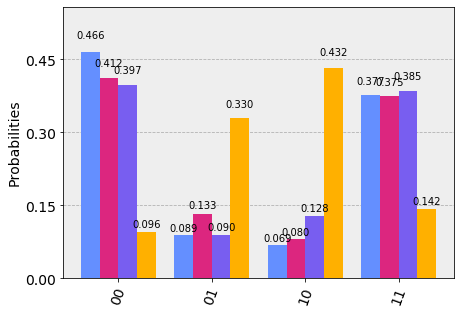

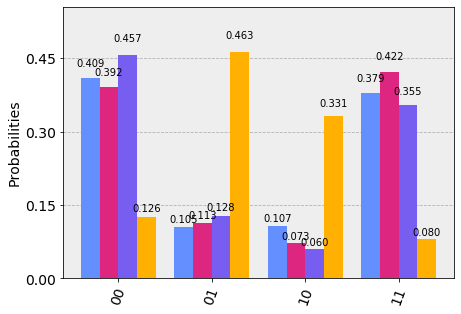

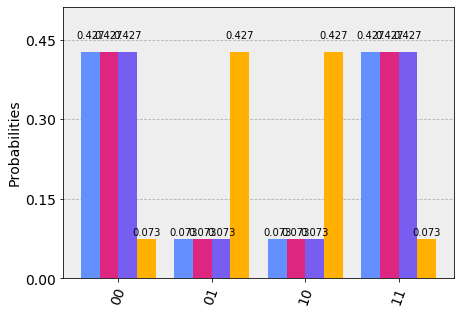

In [16]:
#histogram of measured counts, for each term of the inequality
for p in range(Nqubitpairs):
    fig=plot_histogram(countsPairState[p])
    fig.savefig(os.path.join(dataset,"Hist_p"+str(p)+"_S"+format(InequalityMeasured[p],floatformat).replace(".","_")+".pdf"))
    display(fig)

fig=plot_histogram(theoryCountsMappedToPair) 
fig.savefig(os.path.join(dataset,"Hist_"+"theory"+"_"+"_S"+format(InequalityTheory,floatformat).replace(".","_")+".pdf"))
display(fig)


In [17]:
#Output data

resultA=[[] for i in range(Nqubitpairs)] #alice measuremnt result
resultB=[[] for i in range(Nqubitpairs)] #bob measurement result
measSettingA=[[] for i in range(Nqubitpairs)] #alice measurement Setting
measSettingB=[[] for i in range(Nqubitpairs)] #bob measurement Setting

if(memory==True):
    for p in range(Nqubitpairs):
        print("Output qubit pair",p,"of parallel run")
        print("Generating output bits of measurement results and settings for Alice and Bob")
        shuffleCircuits=flatten([np.ones(totalshots,dtype=int)*i for i in range(NmeasurementSettings)]) #shuffle differen measurement types
        np.random.shuffle(shuffleCircuits)
        for i in range(NmeasurementSettings):
            for j in range(totalshots):
                circuitindex=shuffleCircuits[i*totalshots+j] #use shuffled index
                resultA[p]+=shotsResult[p][circuitindex][j][0]
                resultB[p]+=shotsResult[p][circuitindex][j][1]
                measSettingA[p]+=measSetting[p][circuitindex][j][0]
                measSettingB[p]+=measSetting[p][circuitindex][j][1]

                #output 
        #first file contains Alice Result, Bob result, Alice Measurement settings and Bob measurement Settings
        with open(os.path.join(dataset,'MeasurementsAndSettings_'+"Pair_"+str(p)+"_S"+format(InequalityMeasured[p],floatformat).replace(".","_")+'.txt'), 'w') as the_file:
            the_file.write("".join(resultA[p])+"\n")
            the_file.write("".join(resultB[p])+"\n")
            the_file.write("".join(measSettingA[p])+"\n")
            the_file.write("".join(measSettingB[p]))

        #contains Alice Results and Bob results. Use this for the Extractor
        with open(os.path.join(dataset,'Measurements_'+"Pair_"+str(p)+"_S"+format(InequalityMeasured[p],floatformat).replace(".","_")+'.txt'), 'w') as the_file:
            the_file.write("".join(resultA[p])+"\n")
            the_file.write("".join(resultB[p]))
    
    
#dump all data in pickle
outfile=open( os.path.join(dataset,"outputCHSH_"+".pcl"), "wb" )
pickledict={"date":date,"mode":mode,"machine":machine,'x_boost':x_boost,'jobID':jobID,"shots":shots,"Nrepeatcircuits":Nrepeatcircuits,
            "dimPair":dimPair,"Nqubitpairs":Nqubitpairs,"time_taken":time_taken,"coupling_map_pair":coupling_map_pair,
            "QubitsUsedMeasurementError":QubitsUsedMeasurementError,"CNOTsUsedError":CNOTsUsedError,
            "u3UsedError":u3UsedError,"result":result,"InequalityMeasured":InequalityMeasured,"InequalityTheory":InequalityTheory,'InequalityClassicBound':InequalityClassicBound,"compareExact":compareExact
           }

#pickle.dump([date,mode,machine,shots,Nrepeatcircuits,dimPair,Nqubitpairs,time_taken,coupling_map_pair,QubitsUsedMeasurementError,CNOTsUsedError,u3UsedError,result,InequalityMeasured,InequalityTheory,compareExact], outfile)
pickle.dump(pickledict, outfile)
outfile.close()

print("Finish output")

Output qubit pair 0 of parallel run
Generating output bits of measurement results and settings for Alice and Bob
Output qubit pair 1 of parallel run
Generating output bits of measurement results and settings for Alice and Bob
Finish output
